
## IMPORTING LIBRARY AND DATASET

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore') 


**Importing CNC Machine downtime dataset**

In [36]:
df=pd.read_csv("CNC machine downtime.csv", parse_dates=['DATE'])
df.head()

,Timestamp,DATE,SHIFT,MACHINE NO.,PROBLEM TYPE,MECHANICAL ACTION,ELECTRICAL,TOOLING,SLANT LEADS,DAMAGED AIRCOIL,STRIPPING,UNEVEN WINDING,RED LEAD,START DOWN,START REPAIR,JOB COMPLETE,VERIFY PERSON,VERIFY STATUS,REMARK
0,1/7/2022 8:20,2022-01-07,DAY,CNC 1,SLANT LEADS,NaN,NaN,NaN,ADJUST SLIDER/ PROGRAM,NaN,NaN,NaN,NaN,8:00:00 AM,8:00:00 AM,8:10:00 AM,AMIR SYAFIQ,OK,NaN
1,1/7/2022 8:21,2022-01-07,DAY,CNC 11,SLANT LEADS,NaN,NaN,NaN,ADJUST SLIDER/ PROGRAM,NaN,NaN,NaN,NaN,8:00:00 AM,8:10:00 AM,8:20:00 AM,AMIR SYAFIQ,OK,NaN
2,1/24/2022 8:37:12,2022-01-24,DAY,CNC 5,UNEVEN WINDING,NaN,NaN,NaN,NaN,NaN,NaN,ADJUST PROGRAM WINDING,NaN,8:00:00 AM,8:06:00 AM,8:35:00 AM,AIZAT,OK,NaN
3,1/26/2022 2:03:14,2022-01-25,NIGHT,CNC 5,SLANT LEADS,NaN,NaN,NaN,ADJUST SLIDER/ PROGRAM,NaN,NaN,NaN,NaN,12:45:00 AM,1:00:00 AM,2:00:00 AM,HALIM,OK,NaN
4,1/26/2022 3:31:10,2022-01-25,NIGHT,CNC 10,SLANT LEADS,NaN,NaN,NaN,ADJUST SLIDER/ PROGRAM,NaN,NaN,NaN,NaN,1:00:00 AM,3:00:00 AM,3:30:00 AM,HALIM,OK,NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          65 non-null     object        
 1   DATE               65 non-null     datetime64[ns]
 2   SHIFT              65 non-null     object        
 3   MACHINE NO.        65 non-null     object        
 4   PROBLEM TYPE       65 non-null     object        
 5   MECHANICAL ACTION  9 non-null      object        
 6   ELECTRICAL         2 non-null      object        
 7   TOOLING            5 non-null      object        
 8   SLANT LEADS        17 non-null     object        
 9   DAMAGED AIRCOIL    6 non-null      object        
 10  STRIPPING          16 non-null     object        
 11  UNEVEN WINDING     5 non-null      object        
 12  RED LEAD           1 non-null      object        
 13  START DOWN         65 non-null     object        
 14  START REPAIR


# DATA PREPROCESSING


**Drop columns that are not relevant to analysis**

In [38]:
# drop columns with indices 5 to 12
df.drop(df.columns[[0,5,6,7,8,9,10,11,12,16,17,18]], axis=1, inplace=True)

# print the updated DataFrame
df.head(50)

,DATE,SHIFT,MACHINE NO.,PROBLEM TYPE,START DOWN,START REPAIR,JOB COMPLETE
0,2022-01-07,DAY,CNC 1,SLANT LEADS,8:00:00 AM,8:00:00 AM,8:10:00 AM
1,2022-01-07,DAY,CNC 11,SLANT LEADS,8:00:00 AM,8:10:00 AM,8:20:00 AM
2,2022-01-24,DAY,CNC 5,UNEVEN WINDING,8:00:00 AM,8:06:00 AM,8:35:00 AM
3,2022-01-25,NIGHT,CNC 5,SLANT LEADS,12:45:00 AM,1:00:00 AM,2:00:00 AM
4,2022-01-25,NIGHT,CNC 10,SLANT LEADS,1:00:00 AM,3:00:00 AM,3:30:00 AM
5,2022-01-25,NIGHT,CNC 5,MECHANICAL,3:00:00 AM,3:00:00 AM,3:45:00 AM
6,2022-01-26,DAY,CNC 4,TOOLING,11:00:00 AM,12:00:00 PM,12:30:00 PM
7,2022-02-06,NIGHT,CNC 11,SLANT LEADS,9:15:00 PM,9:50:00 PM,10:05:00 PM
8,2022-02-08,NIGHT,CNC 1,STRIPPING,1:30:00 AM,1:35:00 AM,1:57:00 AM
9,2022-02-08,NIGHT,CNC 11,SLANT LEADS,1:00:00 AM,1:58:00 AM,2:10:00 AM


**Check For Missing Value**

In [39]:
df.isnull().sum()

DATE            0
SHIFT           0
MACHINE NO.     0
PROBLEM TYPE    0
START DOWN      0
START REPAIR    0
JOB COMPLETE    0
dtype: int64

**Check For Duplicates**

In [40]:
#check for duplicates
df[df.duplicated(keep=False)]

,DATE,SHIFT,MACHINE NO.,PROBLEM TYPE,START DOWN,START REPAIR,JOB COMPLETE


There is no null cells and duplicate values detected

**Feature Engineering**

In [41]:
#Convert date column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
df['START DOWN'] = pd.to_datetime(df['DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['START DOWN'])
df['START REPAIR'] = pd.to_datetime(df['DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['START REPAIR'])
df['JOB COMPLETE'] = pd.to_datetime(df['DATE'].dt.strftime('%Y-%m-%d') + ' ' + df['JOB COMPLETE'])

# Add one day to end date if end time is smaller than start time
df.loc[df['JOB COMPLETE'] < df['START DOWN'], 'JOB COMPLETE'] += pd.DateOffset(days=1)

# Calculate duration feature
df['DURATION PER EVENT (hours)'] = (df['JOB COMPLETE'] - df['START DOWN']).dt.total_seconds() / 3600

# Round duration to 2 decimal places
df['DURATION PER EVENT (hours)'] = df['DURATION PER EVENT (hours)'].round(2)
#Create ne feature name last Downtime which is days since last downtime for the same machine
df['last Downtime (days)'] = df.groupby('MACHINE NO.')['DATE'].diff().fillna(pd.Timedelta(days=0)).dt.days
df.head(50)


,DATE,SHIFT,MACHINE NO.,PROBLEM TYPE,START DOWN,START REPAIR,JOB COMPLETE,DURATION PER EVENT (hours),last Downtime (days)
0,2022-01-07,DAY,CNC 1,SLANT LEADS,2022-01-07 08:00:00,2022-01-07 08:00:00,2022-01-07 08:10:00,0.17,0
1,2022-01-07,DAY,CNC 11,SLANT LEADS,2022-01-07 08:00:00,2022-01-07 08:10:00,2022-01-07 08:20:00,0.33,0
2,2022-01-24,DAY,CNC 5,UNEVEN WINDING,2022-01-24 08:00:00,2022-01-24 08:06:00,2022-01-24 08:35:00,0.58,0
3,2022-01-25,NIGHT,CNC 5,SLANT LEADS,2022-01-25 00:45:00,2022-01-25 01:00:00,2022-01-25 02:00:00,1.25,1
4,2022-01-25,NIGHT,CNC 10,SLANT LEADS,2022-01-25 01:00:00,2022-01-25 03:00:00,2022-01-25 03:30:00,2.50,0
5,2022-01-25,NIGHT,CNC 5,MECHANICAL,2022-01-25 03:00:00,2022-01-25 03:00:00,2022-01-25 03:45:00,0.75,0
6,2022-01-26,DAY,CNC 4,TOOLING,2022-01-26 11:00:00,2022-01-26 12:00:00,2022-01-26 12:30:00,1.50,0
7,2022-02-06,NIGHT,CNC 11,SLANT LEADS,2022-02-06 21:15:00,2022-02-06 21:50:00,2022-02-06 22:05:00,0.83,30
8,2022-02-08,NIGHT,CNC 1,STRIPPING,2022-02-08 01:30:00,2022-02-08 01:35:00,2022-02-08 01:57:00,0.45,32
9,2022-02-08,NIGHT,CNC 11,SLANT LEADS,2022-02-08 01:00:00,2022-02-08 01:58:00,2022-02-08 02:10:00,1.17,2


 **Downtime Distribution**

In [42]:
import plotly.express as px

# Create an interactive boxplot with tooltips
fig = px.box(df, y='DURATION PER EVENT (hours)', hover_data=['SHIFT', 'MACHINE NO.', 'PROBLEM TYPE'], width=600, height=600)

# Customize the appearance of the boxplot
fig.update_traces(marker=dict(color='rgb(8, 81, 156)'), line=dict(color='rgb(8, 81, 156)'))
fig.update_layout(title='Boxplot for Duration Per Event (hours)', yaxis_title='Duration (hours)', xaxis_title='Duration Per Event')

# Show the boxplot
fig.show()

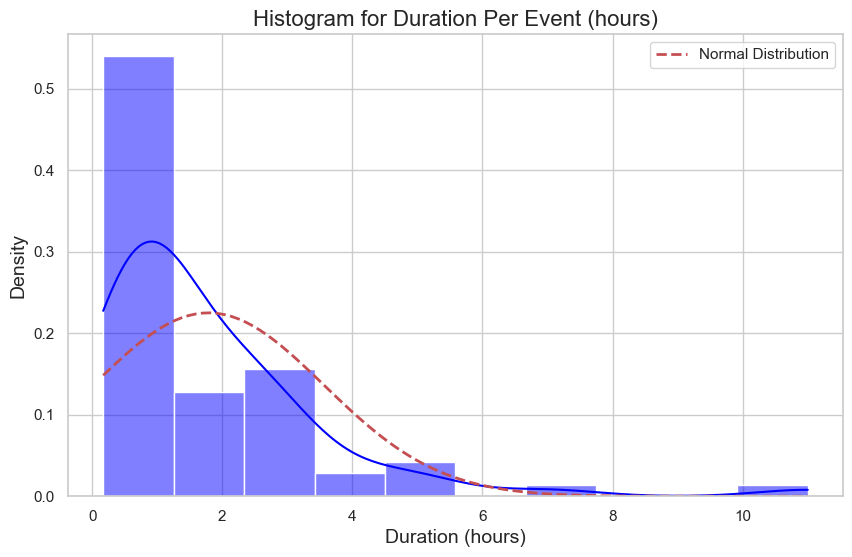

In [43]:
from scipy.stats import norm
# Set the Seaborn style
sns.set(style="whitegrid")

# Create a histogram using Seaborn's distplot (deprecated) or displot (recommended) function
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='DURATION PER EVENT (hours)', kde=True, color='blue', bins=10, stat='density')

# Fit a normal distribution to the data and overlay the curve
mu, std = norm.fit(df['DURATION PER EVENT (hours)'])
x = np.linspace(min(df['DURATION PER EVENT (hours)']), max(df['DURATION PER EVENT (hours)']), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r--', linewidth=2, label='Normal Distribution')

# Customize the appearance of the histogram
plt.title('Histogram for Duration Per Event (hours)', fontsize=16)
plt.xlabel('Duration (hours)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()

**Time Series Structuring**

In [44]:
start_date = '2022-01-01'
end_date = '2023-03-11'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new dataframe with the list of dates
df_dates = pd.DataFrame(date_range, columns=['DATE'])
dash=df[['DATE','MACHINE NO.','PROBLEM TYPE','last Downtime (days)','DURATION PER EVENT (hours)']]
# Set max_rows to None to display all rows
#pd.set_option('display.max_rows', None)
df4 = df_dates.merge(dash, on='DATE', how='left')
df4['DURATION PER EVENT (hours)'] = df4['DURATION PER EVENT (hours)'].fillna(0)

In [45]:
#Filling the null in machine no and problem type
df4['MACHINE NO.'] = df4['MACHINE NO.'].fillna('None')
df4['PROBLEM TYPE'] = df4['PROBLEM TYPE'].fillna('None')

In [46]:
df4.head(12)

,DATE,MACHINE NO.,PROBLEM TYPE,last Downtime (days),DURATION PER EVENT (hours)
0,2022-01-01,None,None,NaN,0.00
1,2022-01-02,None,None,NaN,0.00
2,2022-01-03,None,None,NaN,0.00
3,2022-01-04,None,None,NaN,0.00
4,2022-01-05,None,None,NaN,0.00
5,2022-01-06,None,None,NaN,0.00
6,2022-01-07,CNC 1,SLANT LEADS,0.0,0.17
7,2022-01-07,CNC 11,SLANT LEADS,0.0,0.33
8,2022-01-08,None,None,NaN,0.00
9,2022-01-09,None,None,NaN,0.00


**LABEL ENCODING**

In [47]:
label1 = {'None': 0, 'SLANT LEADS': 1, 'UNEVEN WINDING': 2, 'MECHANICAL': 3, 'TOOLING': 4,
       'STRIPPING': 5, 'ELECTRICAL': 6, 'RED LEAD': 7, 'DAMAGED AIRCOIL': 8,
       'PNEUMATIC': 9, 'UNEVEN LEAD LENGTH': 10, 'WIRE SCRATCH': 11}

label2 ={'None':0, 'CNC 1':1, 'CNC 11':11, 'CNC 4':4, 'CNC 16':16, 'CNC 2':2, 'CNC 10':10,
       'CNC 5':5, 'CNC 13':13, 'CNC 7':7, 'CNC 8':8, 'CNC 14':14, 'CNC 3':3, 'CNC 6':6}

df4['PROBLEM TYPE'] = df4['PROBLEM TYPE'].apply(lambda x: label1[x])
df4['MACHINE NO.']=df4['MACHINE NO.'].apply(lambda x: label2[x])
df4['last Downtime (days)']=df4['last Downtime (days)'].fillna(0).astype(int)

# convert the columns to categorical data type
df4.head()

,DATE,MACHINE NO.,PROBLEM TYPE,last Downtime (days),DURATION PER EVENT (hours)
0,2022-01-01,0,0,0,0.0
1,2022-01-02,0,0,0,0.0
2,2022-01-03,0,0,0,0.0
3,2022-01-04,0,0,0,0.0
4,2022-01-05,0,0,0,0.0


## DESCRIPTIVE ANALYSIS

**1.Time Series Plot for Downtime event in 2022**

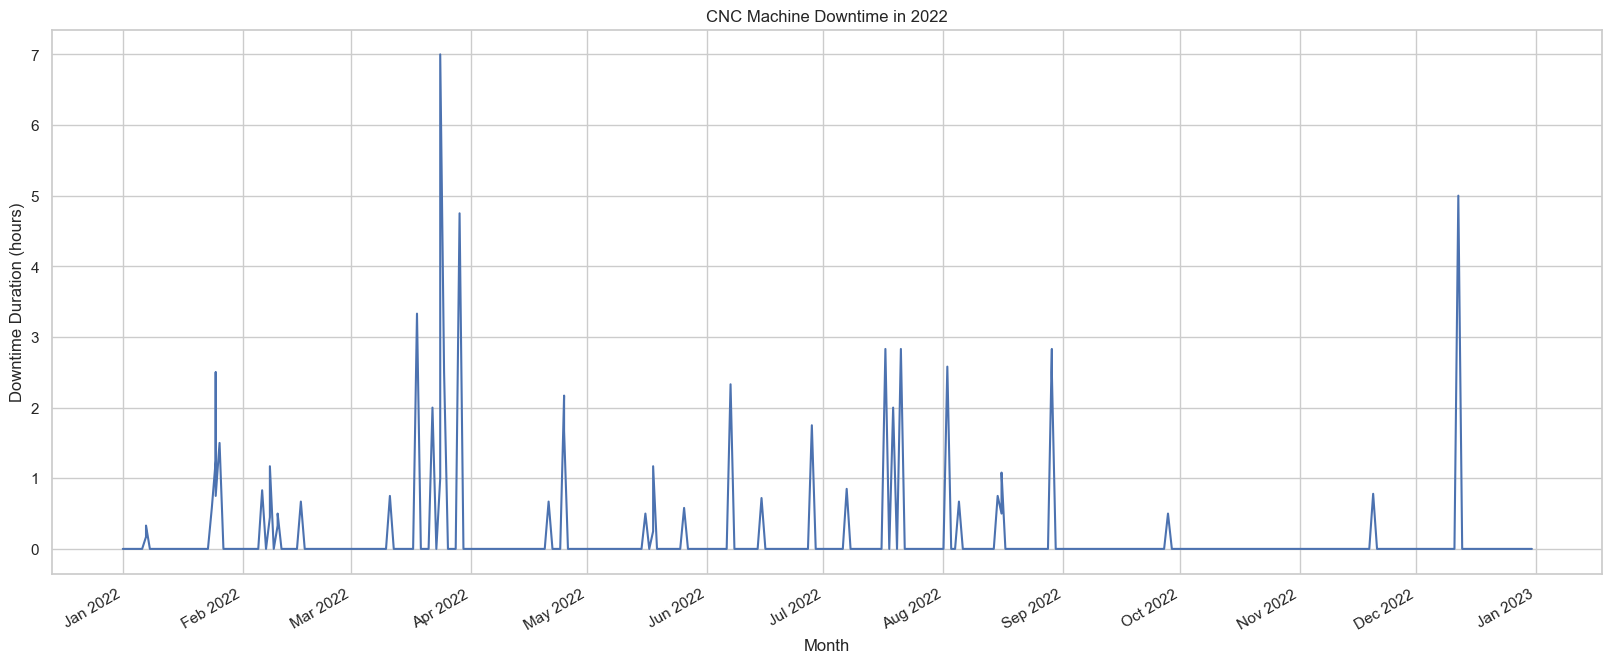

In [16]:
from matplotlib import pyplot
from matplotlib.dates import MonthLocator, DateFormatter

df_2022 = df4.copy()
df_2022 = df_2022.set_index('DATE')
df_2022 = df_2022.loc['2022']

# create a figure and axis objects
fig, ax = pyplot.subplots(figsize=(20, 8))

# plot the data
ax.plot(df_2022.index, df_2022['DURATION PER EVENT (hours)'])

# set axis labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Downtime Duration (hours)')
ax.set_title('CNC Machine Downtime in 2022')

# set x-axis tick locator and formatter
months = MonthLocator()
months_fmt = DateFormatter('%b %Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# rotate the x-axis tick labels for better visibility
fig.autofmt_xdate()

# show the plot
pyplot.show()
# show the plot

 **2. Downtime Statisticss by Month**

In [17]:
# Create a new column for the month name
df_month=df.copy()
df_month = df_month.set_index('DATE')
df_month = df_month.loc['2022']
df_month['Month'] = df_month.index.strftime('%B')

# Group the data by month and calculate the downtime event frequency and total downtime
df_month_stats = df_month.groupby(['Month']).agg({
    'DURATION PER EVENT (hours)': ['count', 'sum']
})
# Rename columns
df_month_stats.columns = ['Downtime Frequency', 'Total Downtime (hours)']
# Sort the months by month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month_stats = df_month_stats.reindex(month_order)
# Display the resulting DataFrame
df_month_stats = df_month_stats.fillna(0)
df_month_stats['Downtime Frequency'] = df_month_stats['Downtime Frequency'].astype(int)
df_month_stats

,Downtime Frequency,Total Downtime (hours)
Month,,
January,7,7.08
February,6,3.95
March,10,31.91
April,3,4.51
May,4,2.50
June,3,4.80
July,4,8.51
August,8,11.74
September,1,0.50


**3.Downtime Statistics by Machine for year 2022**

In [18]:
# calculate total, average, and max downtime for each machine, as well as frequency
df_machine_stats = df_2022.groupby(['MACHINE NO.']).agg({
    'DURATION PER EVENT (hours)': ['sum', ('mean', 'mean'), ('max', 'max'), ('count', 'count')]
})
# rename columns
df_machine_stats.columns = ['TOTAL (Hours)', 'AVERAGE (Hours)', 'MAX  (Hours)', 'FREQUENCY']
# sort machines by machine number
df_machine_stats = df_machine_stats.sort_index()
# format average downtime to 2 decimal places
df_machine_stats['AVERAGE (Hours)'] = df_machine_stats['AVERAGE (Hours)'].round(2)


# calculate average last downtime days for each machine
df_avg_last_downtime = df4.groupby('MACHINE NO.')['last Downtime (days)'].mean().astype(int)
# rename the resulting column
df_avg_last_downtime = df_avg_last_downtime.rename('AVERAGE DAYS BETWEEN DOWNTIME')
# display the resulting dataframe
df_machine = pd.merge(df_machine_stats, df_avg_last_downtime, on='MACHINE NO.', how='outer')
# remove machine number 0
df_machine= df_machine.drop(0, axis=0)
# display the resulting dataframe
df_machine

,TOTAL (Hours),AVERAGE (Hours),MAX (Hours),FREQUENCY,AVERAGE DAYS BETWEEN DOWNTIME
MACHINE NO.,,,,,
1,9.42,1.35,4.75,7.0,38
2,9.75,1.62,3.08,6.0,32
4,10.74,2.15,2.83,5.0,45
5,3.08,0.77,1.25,4.0,61
6,0.50,0.50,0.50,1.0,0
7,1.00,1.00,1.00,1.0,117
8,11.50,3.83,7.00,3.0,39
10,13.17,3.29,5.00,4.0,76
11,7.08,1.18,2.50,6.0,47


Interpretation:\
1.Machine 10 and 8 has the highest total downtime\
2.Machine 3,9,12,15 have no downtime recorded in 2022, this is because machine is not on production due to certain product not having demand\
3.Machine 6 has 0 average day between downtime because downtime for machine only occur once\
4.Machine 14 has the lowest count of day between downtime\
5.Machine 1,2 and 11 has the highest frequency of breakdown among all other machine

 **4. Downtime Statistics By Problem Type**

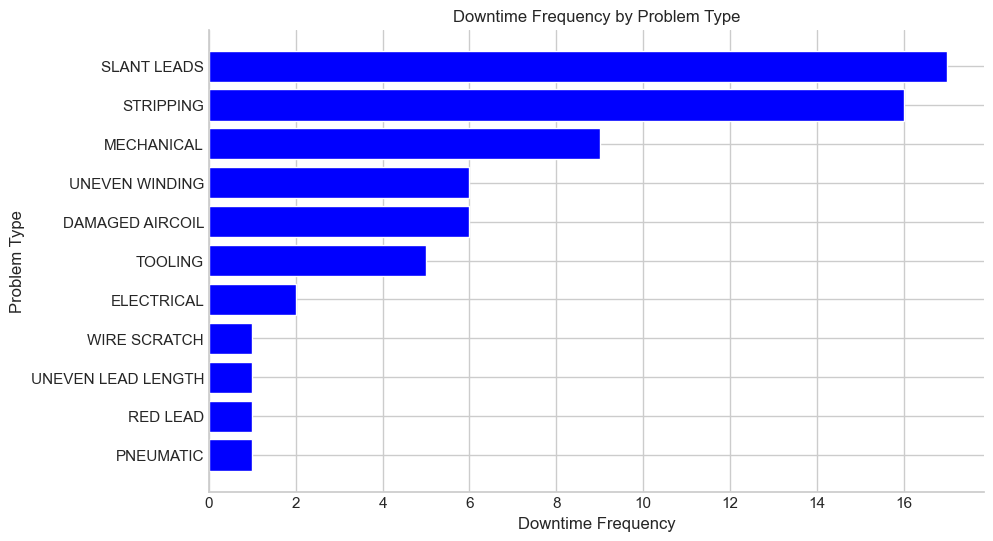

In [19]:
#DOWNTIME FREQUENCY BY PROBLEM TYPE
import matplotlib.pyplot as plt

# create a new dataframe with the downtime frequency by problem type
df_problem_freq = df.groupby('PROBLEM TYPE')['DURATION PER EVENT (hours)'].count().sort_values(ascending=True)

# create the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_problem_freq.index, df_problem_freq.values, color='blue')

# set the axis labels and title
ax.set_xlabel('Downtime Frequency')
ax.set_ylabel('Problem Type')
ax.set_title('Downtime Frequency by Problem Type')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remove ticks
ax.tick_params(axis='both', which='both', length=0)

plt.show()

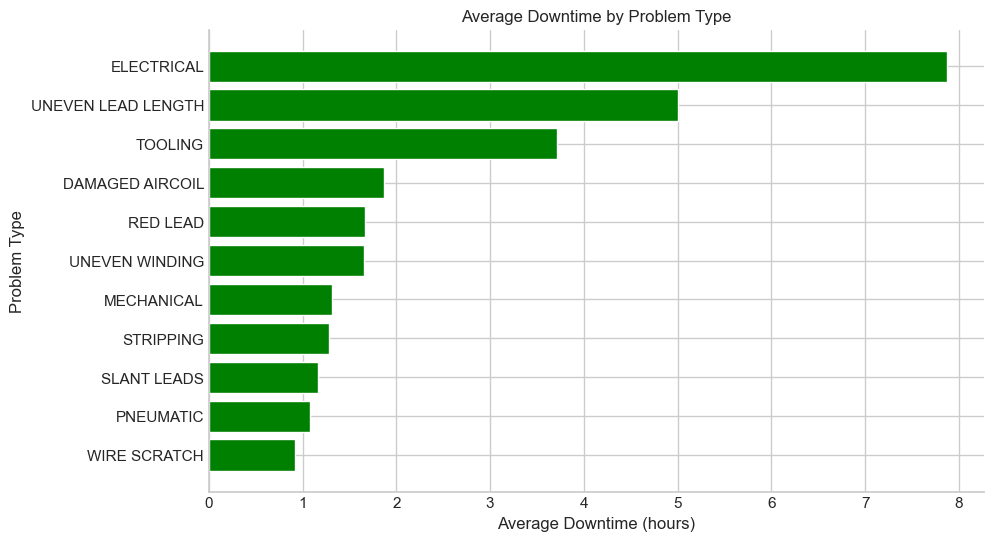

In [20]:
#AVERAGE DOWNTIME BY PROBLEM TYPE
import matplotlib.pyplot as plt

# create a new dataframe with the average downtime by problem type
df_problem_avg = df.groupby('PROBLEM TYPE')['DURATION PER EVENT (hours)'].mean().sort_values(ascending=True)

# create the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df_problem_avg.index, df_problem_avg.values, color='green')

# set the axis labels and title
ax.set_xlabel('Average Downtime (hours)')
ax.set_ylabel('Problem Type')
ax.set_title('Average Downtime by Problem Type')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remove ticks
ax.tick_params(axis='both', which='both', length=0)

plt.show()

Interpretation:\
1.Slant lead is the most frequent problem type causing downtime followed by Stripping and mechanical.\
2.Problems due to Electrical,uneven lead length and tooling has the top highest average downtime,meaning these type of problems took longer for technical support to repair.

**5. Correlation of Machine Number and Problem Type**

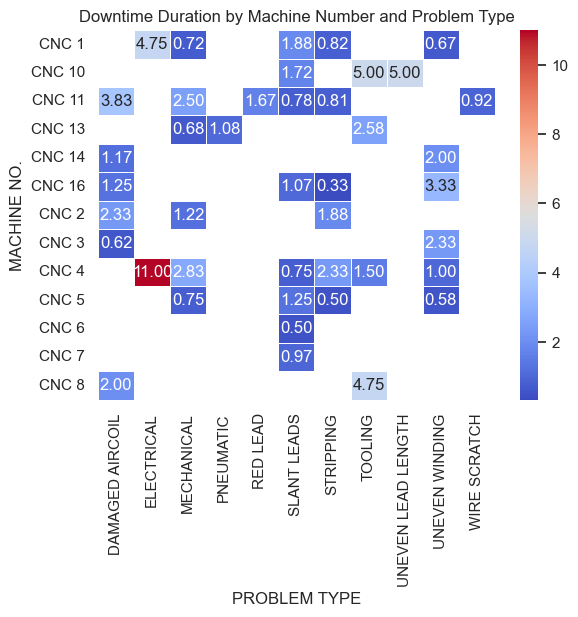

In [27]:
import seaborn as sns

# create a pivot table with machine number as rows, problem type as columns, and downtime duration as values
pivot_table = df.pivot_table(index='MACHINE NO.', columns='PROBLEM TYPE', values='DURATION PER EVENT (hours)', aggfunc='mean')

# create the heatmap
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)

# set the title
plt.title('Downtime Duration by Machine Number and Problem Type')

plt.show()

# TIME SERIES FORECASTING

In [28]:
#Create rows for missing date/gaps
df5=df4.drop(['last Downtime (days)'], axis=1)
# create new column 'category' based on 'value'
df5['Downtime Occurence'] = df5['DURATION PER EVENT (hours)'].apply(lambda x: 0 if x == 0 else 1)
df5.drop('DURATION PER EVENT (hours)',axis=1, inplace=True)
df5['Downtime Occurence'] = df5['Downtime Occurence'].astype('category')

In [29]:
# Calculate probabilities for each category in the 'MACHINE NO.' column
machine_no_prob = df5['MACHINE NO.'].value_counts(normalize=True)

# Calculate probabilities for each category in the 'PROBLEM TYPE' column
problem_type_prob = df5['PROBLEM TYPE'].value_counts(normalize=True)

# Calculate probabilities for each category in the 'Downtime Occurence' column
downtime_occurrence_prob =df5['Downtime Occurence'].value_counts(normalize=True)
# Remove machine 0 from the probability dictionary and recalculate the probabilities
machine_no_prob_no_zero = machine_no_prob[machine_no_prob.index != 0]
machine_no_prob_no_zero = machine_no_prob_no_zero / machine_no_prob_no_zero.sum()

print("Probabilities for each category in the 'Downtime Occurence' column:")
print(downtime_occurrence_prob)

print("Probabilities for each category in the 'MACHINE NO.' column (excluding machine 0):")
print(machine_no_prob_no_zero)

Probabilities for each category in the 'Downtime Occurence' column:
0    0.856512
1    0.143488
Name: Downtime Occurence, dtype: float64
Probabilities for each category in the 'MACHINE NO.' column (excluding machine 0):
1     0.169231
11    0.138462
4     0.138462
16    0.092308
2     0.092308
10    0.076923
5     0.061538
13    0.061538
7     0.046154
8     0.046154
14    0.030769
3     0.030769
6     0.015385
Name: MACHINE NO., dtype: float64


In [30]:
import pandas as pd

def create_conditional_prob_table(machine_problem_counts):
    """Convert the machine problem counts DataFrame to a table of conditional probabilities."""
    prob_table = pd.pivot_table(machine_problem_counts,
                                values='conditional_prob',
                                index='MACHINE NO.',
                                columns='PROBLEM TYPE',
                                fill_value=0)
    return prob_table

# Group the dataset by "MACHINE NO." and "PROBLEM TYPE" and count the occurrences of each combination
machine_problem_counts = df5[df5['Downtime Occurence'] == 1].groupby(['MACHINE NO.', 'PROBLEM TYPE']).size().reset_index(name='count')

# Group the dataset by "MACHINE NO." and count the occurrences of each machine
machine_counts = df5[df5['Downtime Occurence'] == 1].groupby('MACHINE NO.').size()

# Divide the count of each combination by the count of each machine to get the conditional probabilities
machine_problem_counts['conditional_prob'] = machine_problem_counts.apply(lambda row: row['count'] / machine_counts[row['MACHINE NO.']], axis=1)

# Round the conditional probabilities to 4 decimal places
machine_problem_counts['conditional_prob'] = machine_problem_counts['conditional_prob'].round(4)

# Create the conditional probability table
conditional_prob_table = create_conditional_prob_table(machine_problem_counts)

# Print the conditional probability table
conditional_prob_table

PROBLEM TYPE,1,2,3,4,5,6,7,8,9,10,11
MACHINE NO.,,,,,,,,,,,
1,0.1818,0.0909,0.0909,0.0000,0.5455,0.0909,0.0000,0.0000,0.00,0.0,0.0000
2,0.0000,0.0000,0.5000,0.0000,0.3333,0.0000,0.0000,0.1667,0.00,0.0,0.0000
3,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.00,0.0,0.0000
4,0.1111,0.1111,0.1111,0.1111,0.4444,0.1111,0.0000,0.0000,0.00,0.0,0.0000
5,0.2500,0.2500,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.00,0.0,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.0000
8,0.0000,0.0000,0.0000,0.6667,0.0000,0.0000,0.0000,0.3333,0.00,0.0,0.0000
10,0.6000,0.0000,0.0000,0.2000,0.0000,0.0000,0.0000,0.0000,0.00,0.2,0.0000


In [31]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta, date
random.seed(43)

# Define the start and end dates
start_date = date(2023, 3, 12)
end_date = date(2023, 12, 31)

# Function to generate dates in the given range
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield start_date + timedelta(n)

# Probabilities for Downtime Occurence and Machine Numbers (excluding machine 0)
downtime_occurrence_probs = [0.856512, 0.143488]
machine_no_probs = list(machine_no_prob_no_zero.values)

# Create the new dataset
data = []
for single_date in daterange(start_date, end_date):
    row = {}
    row["DATE"] = single_date
    
    if single_date.weekday() == 6: # 6 represents Sunday
        downtime_occurrence = 0
    else:
        downtime_occurrence = np.random.choice([0, 1], p=downtime_occurrence_probs)
    row["Downtime Occurence"] = downtime_occurrence

    if downtime_occurrence == 0:
        row["MACHINE NO."] = 0
        row["PROBLEM TYPE"] = 0
    else:
        machine_no = np.random.choice(machine_no_prob_no_zero.index, p=machine_no_probs)
        row["MACHINE NO."] = machine_no

        # Use the conditional probability table to determine problem type
        problem_type_probs = conditional_prob_table.loc[machine_no]
        problem_type_probs = problem_type_probs[problem_type_probs != 0] # remove problem types with zero probability
        problem_type_probs = problem_type_probs / problem_type_probs.sum() # normalize the probabilities
        problem_type = np.random.choice(problem_type_probs.index, p=problem_type_probs.values)
        row["PROBLEM TYPE"] = problem_type
        data.append(row)

# Convert the data to a pandas DataFrame
new_dataset = pd.DataFrame(data)
new_dataset

,DATE,Downtime Occurence,MACHINE NO.,PROBLEM TYPE
0,2023-03-21,1,4,5
1,2023-04-07,1,13,9
2,2023-04-11,1,1,2
3,2023-04-19,1,11,8
4,2023-05-13,1,4,2
5,2023-05-15,1,2,5
6,2023-05-27,1,16,1
7,2023-06-02,1,1,6
8,2023-06-07,1,11,1
9,2023-06-26,1,1,6


In [32]:
df12= new_dataset[(new_dataset != 0).all(axis=1)].drop('Downtime Occurence', axis=1)
df4.drop(['last Downtime (days)'], axis=1,inplace=True)
dtrain =df4[(df4 != 0).all(axis=1)]
dtrain.drop('DATE',axis=1,inplace=True)

## STEP 1 & 2: TRAIN MODEL & FIT DATA TO MODEL

In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

np.random.seed(43)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, mae, mape

# Prepare the dataset
X = dtrain.drop('DURATION PER EVENT (hours)', axis=1)  # Features
y = dtrain['DURATION PER EVENT (hours)']  # Target

# Split the data into training and testing sets using a percentage-based approach
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

### RANDOM FOREST TIME SERIES FORECAST MODEL

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_model = RandomForestRegressor(random_state=42)

rf_mse,rf_rmse, rf_mae, rf_mape = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)

print("Random Forest:")
print("Mean Squared Error:",rf_mse)
print("Root Mean Squared Error:", rf_rmse)
print("Mean Absolute Error:", rf_mae)


Random Forest:
Mean Squared Error: 2.1050469852096616
Root Mean Squared Error: 1.450878004936894
Mean Absolute Error: 1.0900042762792774


### XGBOOST TIME SERIES FORECAST MODEL

In [46]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(random_state=42)

xgb_mse, xgb_rmse, xgb_mae, xgb_mape = train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

print("XGBoost:")
print("Mean Squared Error:",xgb_mse)
print("Root Mean Squared Error:", xgb_rmse)
print("Mean Absolute Error:", xgb_mae)

XGBoost:
Mean Squared Error: 2.656096937900545
Root Mean Squared Error: 1.6297536433156223
Mean Absolute Error: 1.2292332983016967


## STEP 3: DIAGNOSTIC CHECKING

In [63]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name, cv=10, scoring='neg_mean_absolute_error'):

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv,
                                                           scoring='neg_mean_absolute_error')
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training MAE')  # Multiply by -1 and change label
    plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validation MAE')  # Multiply by -1 and change label
    plt.legend()
    plt.xlabel('Number of training examples')
    plt.ylabel('Mean Absolute Error')  # Change ylabel to 'Mean Absolute Error'
    plt.title(f'Learning Curve ({model_name})')

    # Set the y-axis range and tick interval
    plt.ylim(0, 3)
    plt.yticks(np.arange(0, 3.1, 0.5))

    plt.show()

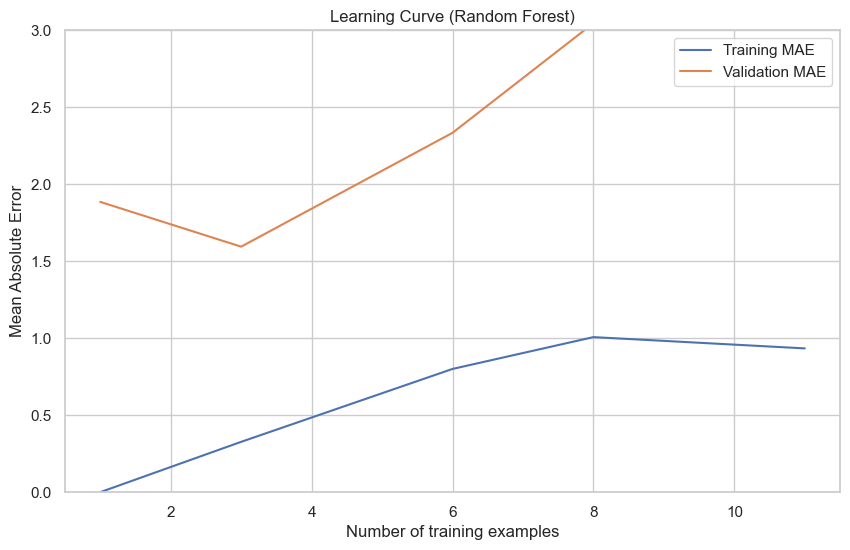

In [64]:
plot_learning_curve(rf_model, X_test, y_test, 'Random Forest')

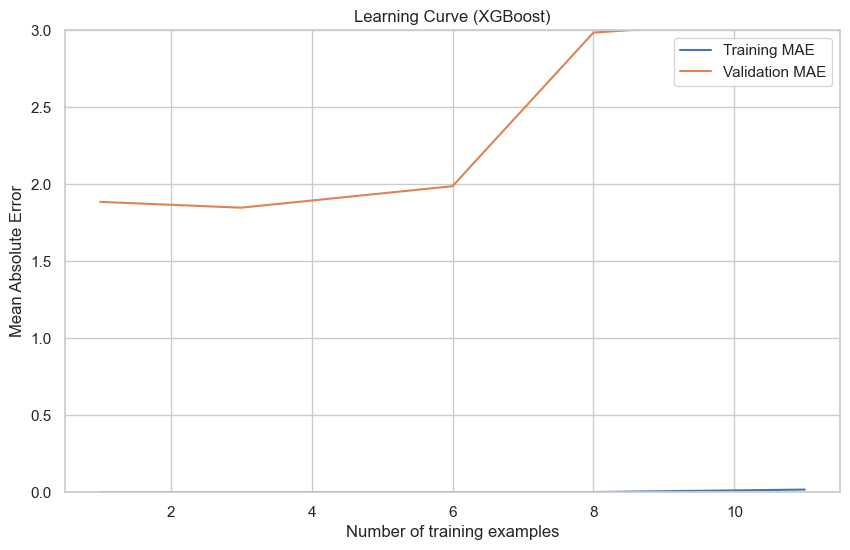

In [65]:
plot_learning_curve(xgb_model, X_test, y_test, 'XGBoost')

## STEP 4: HYPER PARAMETER TUNING USING RANDOMIZED SEARCH

**Random Forest Hyperparameter Tuning**

In [36]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter distribution for RandomizedSearchCV
rf_params_dist = {
    'n_estimators': list(np.arange(50, 500, 10)),
    'max_depth': list(np.arange(1, 11)) + [None],
    'min_samples_split': list(np.arange(2, 11)),
    'min_samples_leaf': list(np.arange(1, 5)),
    'max_features': ['auto', 'sqrt']
}

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor instance
rf_model = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV instance
rf_randomized = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_params_dist,
                                   n_iter=50, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42)

# Perform the randomized search
rf_randomized.fit(X_train, y_train)

# Train the Random Forest model using the best hyperparameters from the randomized search
rf_tuned = RandomForestRegressor(**rf_randomized.best_params_, random_state=42)
rf_tuned.fit(X_train, y_train)

# Predict the values for the test set
y_pred_rf = rf_tuned.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

print("Best parameters for Random Forest:", rf_randomized.best_params_)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Random Forest: {'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}
Mean Squared Error: 1.2654206388989524
Root Mean Squared Error: 1.1249091691772062
Mean Absolute Error: 0.9429684650145945


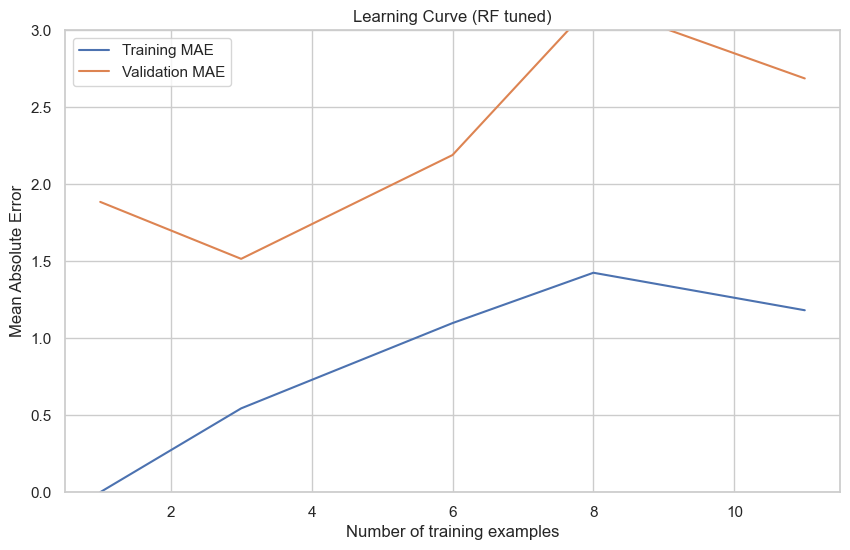

In [67]:
plot_learning_curve(rf_tuned, X_test, y_test, 'RF tuned')

**XGBoost Hyperarameter Tuning**

In [37]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter distribution for RandomizedSearchCV
xgb_params_dist = {
    'n_estimators': list(np.arange(50, 500, 10)),
    'max_depth': list(np.arange(1, 11)),
    'learning_rate': list(np.logspace(-3, 0, 20)),
    'subsample': list(np.linspace(0.5, 1, 20)),
    'colsample_bytree': list(np.linspace(0.5, 1, 20))
}

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBRegressor instance
xgb_model = xgb.XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV instance
xgb_randomized = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params_dist,
                                    n_iter=50, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1, random_state=42)

# Perform the randomized search
xgb_randomized.fit(X_train, y_train)

# Train the XGBoost model using the best hyperparameters from the randomized search
xgb_tuned = xgb.XGBRegressor(**xgb_randomized.best_params_, random_state=42)
xgb_tuned.fit(X_train, y_train)

# Predict the values for the test set
y_pred_xgb = xgb_tuned.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
print("Best parameters for XGBoost:", xgb_randomized.best_params_)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost: {'subsample': 0.868421052631579, 'n_estimators': 430, 'max_depth': 6, 'learning_rate': 0.00206913808111479, 'colsample_bytree': 0.7894736842105263}
Mean Squared Error: 0.40172650531061116
Root Mean Squared Error: 0.6338189846561959
Mean Absolute Error: 0.46978025491421044


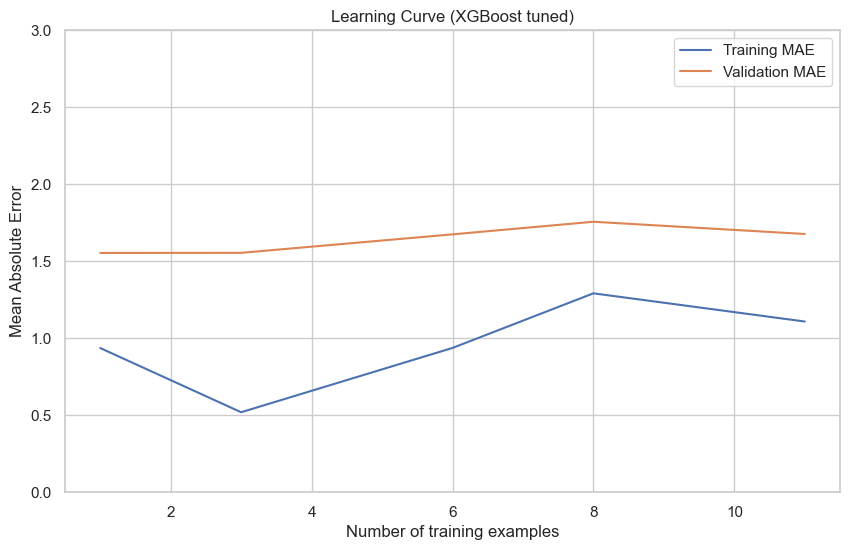

In [68]:
plot_learning_curve(xgb_tuned, X_test, y_test, 'XGBoost tuned')

## STEP 5: USE BEST MODEL TO FORECAST 2023 DOWNTIME 

As we can see from the performance metrics of both model after applying tune hyper parameter, XGBoost model has overall better performance with lower value of RMSE MAE and MAPE when compared to Random Forest

In [38]:
#MAKING PREDICTION USING TRAINED XGB MODEL
df13 = df12.drop('DATE', axis=1)

# Predict the 'DURATION PER EVENT (hours)' using the trained model
predicted_durations = xgb_tuned.predict(df13)
rounded_durations = np.round(predicted_durations, 2)

# Add the predicted durations to the DataFrame
df13['DURATION PER EVENT (hours)'] = rounded_durations

# Insert the 'DATE' column as the second column in the DataFrame
df13.insert(loc=0, column='DATE', value=df12['DATE'])
df13

,DATE,MACHINE NO.,PROBLEM TYPE,DURATION PER EVENT (hours)
0,2023-03-21,4,5,1.47
1,2023-04-07,13,9,0.96
2,2023-04-11,1,2,1.03
3,2023-04-19,11,8,1.14
4,2023-05-13,4,2,1.48
5,2023-05-15,2,5,1.05
6,2023-05-27,16,1,0.93
7,2023-06-02,1,6,2.42
8,2023-06-07,11,1,0.97
9,2023-06-26,1,6,2.42


In [ ]:
# Ensure the 'DATE' column in df12 is of datetime64[ns] type
df13['DATE'] = pd.to_datetime(df13['DATE'])

# Create a new DataFrame containing dates from 12/3/2023 to 31/12/2023
date_range = pd.date_range(start='2023-03-12', end='2023-12-31')
df_dates = pd.DataFrame(date_range, columns=['DATE'])

# Merge the new DataFrame with the existing one on the date column
df_merged = pd.merge(df_dates, df13, on='DATE', how='left')
df_merged.fillna(0, inplace=True)

# Convert the 'PROBLEM TYPE' and 'MACHINE NO.' columns to integer data type
df_merged['PROBLEM TYPE'] = df_merged['PROBLEM TYPE'].astype(int)
df_merged['MACHINE NO.'] = df_merged['MACHINE NO.'].astype(int)

In [ ]:
df_merged

In [ ]:
# Set the 'DATE' column as the index for df4
# Concatenate df4 and df_merged on the index
df_final = pd.concat([df4, df_merged])
#inverse transform the encoded label
inverse_label1 = {v: k for k, v in label1.items()}
inverse_label2 = {v: k for k, v in label2.items()}
df_final['PROBLEM TYPE'] = df_final['PROBLEM TYPE'].apply(lambda x: inverse_label1[x])
df_final['MACHINE NO.'] = df_final['MACHINE NO.'].apply(lambda x: inverse_label2[x])
# Reset the index of df_final
df_final = df_final.reset_index()

# Create new feature 'last Downtime (days)' which is days since last downtime for the same machine
df_final['last Downtime (days)'] = df_final.groupby('MACHINE NO.')['DATE'].diff().fillna(pd.Timedelta(days=0)).dt.days
df_final.loc[df_final['PROBLEM TYPE'] == 'None', 'last Downtime (days)'] = 0
df_final = df_final.drop(columns=['index'])
# Set the 'DATE' column as the index for df_final
df_final = df_final.set_index('DATE')

In [ ]:
df_final

In [ ]:
#df_final.to_csv('CNC Downtime Prediction 2023.csv')